# Moscow code tutorial

Let's create a new design from scratch! In order to do this, you'll need to have the KLayout independent module installed. Follow the instructions in https://github.com/KLayout/klayout/wiki/KLayout-Python-Module to install it

# Basic (RUN ALL CELLS IN THIS CATEGORY)

First, we import the klayout.db library, which contains all the tools to create geometrical shapes, layering etc.

At this point, I recommend having a instance of KLayout opened on the side.

In [10]:
import klayout.db as db
import os
import numpy as np

working_path = os.getcwd()

# Change directory to current directory of the Moscow Libraries and import it
os.chdir(r'Z:\Fabrication\Designs\Design playground')

from ClassLib import *

# Change back to original working directory
os.chdir(working_path)

We can create a basic layout in which all the designs will be appended to, as well as define its dbu units. After that, we need to create a layer in which we'll create our design

In [11]:
# Create a Klayout Layout object
layout = db.Layout()

# Make all numeric references to be in nm
layout.dbu = 0.001

# Check whether a Cell of name BasicCell exists. If it doesn't, create it.
if( layout.has_cell( "BasicCell") ):
    pass
else:
    cell = layout.create_cell( "BasicCell" )

# Create a basic layer (10, 0) in KLayout
layer_info_photo = db.LayerInfo(10,0)
layer_photo = layout.layer( layer_info_photo )


---

<div align="center">
  Run all cells above in order to load the basic packages and libraries, as well as define the basic KLayout objects
</div>

---

## Creating a basic chip

Now, we can write a box as a test

In [12]:
box = db.DBox(0, 0, 10, 200)
cell.shapes( layer_photo ).insert( box ) 

box (0,0;10000,200000)

Since we have a basic layout, let's save it

In [13]:
layout.write(r'Example.gds')

Now that we have a basic layout, we can check how it looks in KLayout. Open the file 'Example.gds' in KLayout. You should see a rectangle in layer 10/0. Every time you save the gds file from now on, KLayout will ask to reload so you can check the progress you're making.

In this section we will create a chip with a CPW and two launchers, which is the basics of any superconducting 2D design.

In [14]:
class CHIP:
    
    '''
    Basic class with chip parameters in order to easily reproduce it'''
    dx = 7.1e6
    dy = 2.1e6
    L1 = 2.5e6
    gap = 150.e3
    width = 260.e3
    b = 2*gap + width
    origin = db.DPoint( 0,0 )
    box = db.DBox( origin, origin + db.DPoint( dx,dy ) )
    # only 4 connections programmed by now
    connections = [box.p1 + db.DPoint( L1 + b/2,0 ), box.p1 + db.DPoint( dx - (L1+b/2),0 ), box.p2 - db.DPoint( L1 + b/2,0 ),  box.p1 + db.DPoint( L1 + b/2, dy )]

In [15]:
# Define several layers as a test. You can create as many as you want as long as they are numbered differently
layer_info_photo = db.LayerInfo(10,0)
layer_info_el = db.LayerInfo(11,0)
layer_crosses = db.LayerInfo(2, 0)
layer_text = db.LayerInfo(3, 0)
layer_negative = db.LayerInfo(4, 0)
layer_photo = layout.layer( layer_info_photo )
layer_el = layout.layer( layer_info_el )
layer_cross = layout.layer(layer_crosses)
layer_txt = layout.layer(layer_text)
layer_neg = layout.layer(layer_negative)

Let us draw the basic chip with crosses to delimit its boundaries.

The next cell defines the number of repetitions of the chip design that you would like to do. If N_repetitions is greater than 1, you also have a list of relative origins for each repetition of the chip in origins. Consider whether you would like to create this repetitions in the code or just copy them directly in KLayout.

It also defines a DPoint and Vector versions of the origin, since different classes may use both of them.

Finally, it creates the basic chip geometry in the layer_photo layer.

In [16]:
N_repetitions = 1
Origin_list = [(0, n*(CHIP.dy))for n in range(N_repetitions)]
origins = Origin_list[0]
origin = db.DPoint( origins[0], origins[1] )
Origin_V = Vector( origins[0], origins[1] )
cell.shapes( layer_photo ).insert( db.Box( origin, Point( origins[0] + CHIP.dx, origins[1] + CHIP.dy ) ) )

box (0,0;7100000,2100000)

In [17]:
layout.write(r'Example.gds')

As you can see, we can draw different objects in different layers. For example, in the following cell we create two sets of crosses at the ends of the chip, and in different layers.

In [18]:
# Draw crosses for reference

cross_small = 50e3
cross_small_neg = 100e3
cross_large = 500e3
cross_large_neg = 550e3

cross_ll = Cross( Origin_V + Vector(-(cross_large)/2, -(cross_large)/2), cross_small, cross_large )
cross_ll.place(cell, layer_cross)
cross_lr = Cross( Origin_V + Vector(CHIP.dx, 0)+ Vector(-(cross_large)/2, -(cross_large)/2 ), cross_small, cross_large )
cross_lr.place(cell, layer_cross)
cross_ul = Cross( Origin_V + Vector(0, CHIP.dy)+ Vector(-(cross_large)/2, -(cross_large)/2), cross_small, cross_large )
cross_ul.place(cell, layer_cross)
cross_lr = Cross( Origin_V + Vector(CHIP.dx, CHIP.dy)+ Vector(-(cross_large)/2, -(cross_large)/2 ), cross_small, cross_large )
cross_lr.place(cell, layer_cross)

#Negative crosses
cross_ll = Cross( Origin_V + Vector(-(cross_large_neg)/2, -(cross_large_neg)/2), cross_small_neg, cross_large_neg)
cross_ll.place(cell, layer_neg)
cross_lr = Cross( Origin_V + Vector(CHIP.dx, 0)+ Vector(-(cross_large_neg)/2, -(cross_large_neg)/2 ), cross_small_neg, cross_large_neg  )
cross_lr.place(cell, layer_neg)
cross_ul = Cross( Origin_V + Vector(0, CHIP.dy)+ Vector(-(cross_large_neg)/2, -(cross_large_neg)/2), cross_small_neg, cross_large_neg  )
cross_ul.place(cell, layer_neg)
cross_lr = Cross( Origin_V + Vector(CHIP.dx, CHIP.dy)+ Vector(-(cross_large_neg)/2, -(cross_large_neg)/2 ), cross_small_neg, cross_large_neg  )
cross_lr.place(cell, layer_neg)

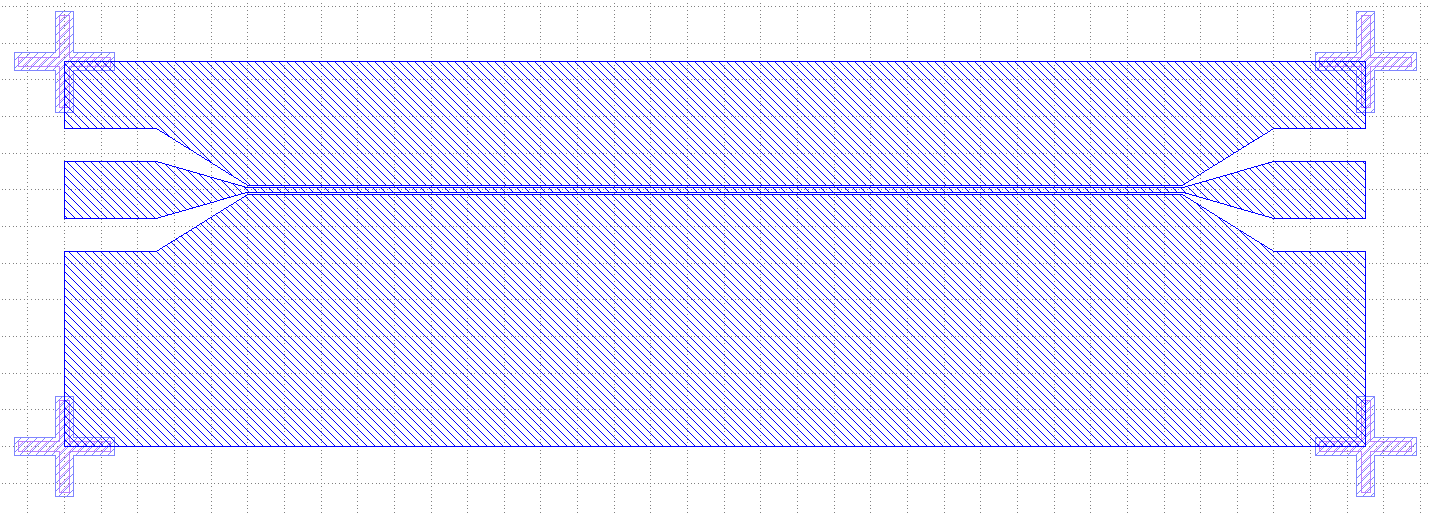

In [19]:
layout.write(r'Example.gds')

from IPython.display import Image
Image(filename='Z:/DataAnalysis/Notebooks/Design_Tests/First_GDS.png')

Check the gds file to see the different layers. Now, let's say we want to draw the most basic CPW, with launchers on both sides. We first create a CPW line going from the contact Length to the edge of the chip (CHIP.dx)-contact length. Then we create a contact pad on the left using a CPW of different height and width, and using the function CPW2CPW to join them together

In [20]:
# Contact Length of the Launchers
contact_L = 1e6

# The code below creates the central CPW feedline
width = 24.1e3
gap = 12.95e3
#p1 = DPoint( 0 , CHIP.dy*2/3 )
#p2 = DPoint( CHIP.dx, CHIP.dy*2/3 )
p1 = origin + DPoint( 0 + contact_L, CHIP.dy*2/3 )
p2 = origin + DPoint( CHIP.dx - contact_L, CHIP.dy*2/3 )
Z0 = CPW( width, gap, p1, p2 )
Z0.place( cell, layer_photo )

In [21]:
layout.write(r'Example.gds')

In [22]:
# This cell creates the left launcher using a CPW of different width and gaps.

# left contact pad
width_launcher = CHIP.width*1.2
gap_launcher = CHIP.gap*1.2
p3 = origin + DPoint( 0, CHIP.dy*2/3 )
p4 = origin + DPoint( contact_L/2, CHIP.dy*2/3 )
Z1 = CPW( width_launcher, gap_launcher, p3, p4 )
Z1.place( cell, layer_photo )

In [23]:
# This cell draws an adapter between the launcher and the central feedline CPWs, which will bridge them together
adapter1 = CPW2CPW( Z1, Z0, p4, p1 )
adapter1.place( cell, layer_photo )

In [24]:
# Same as both cells above, for the right side
# right contact pad
width1 = CHIP.width*1.2
gap1 = CHIP.gap*1.2
p5 = origin + DPoint( CHIP.dx - contact_L/2, CHIP.dy*2/3 )
p6 = origin + DPoint( CHIP.dx, CHIP.dy*2/3 )
Z2 = CPW( width1, gap1, p5, p6 )
Z2.place( cell, layer_photo )

adapter1 = CPW2CPW( Z2, Z0, p5, p2 )
adapter1.place( cell, layer_photo )

Now, let us save the gds file and check! At this point, we should have a square chip, with crosses in its edges and a CPW going from one edge to the other, with its launchers included.

In [25]:
layout.write(r'Example.gds')

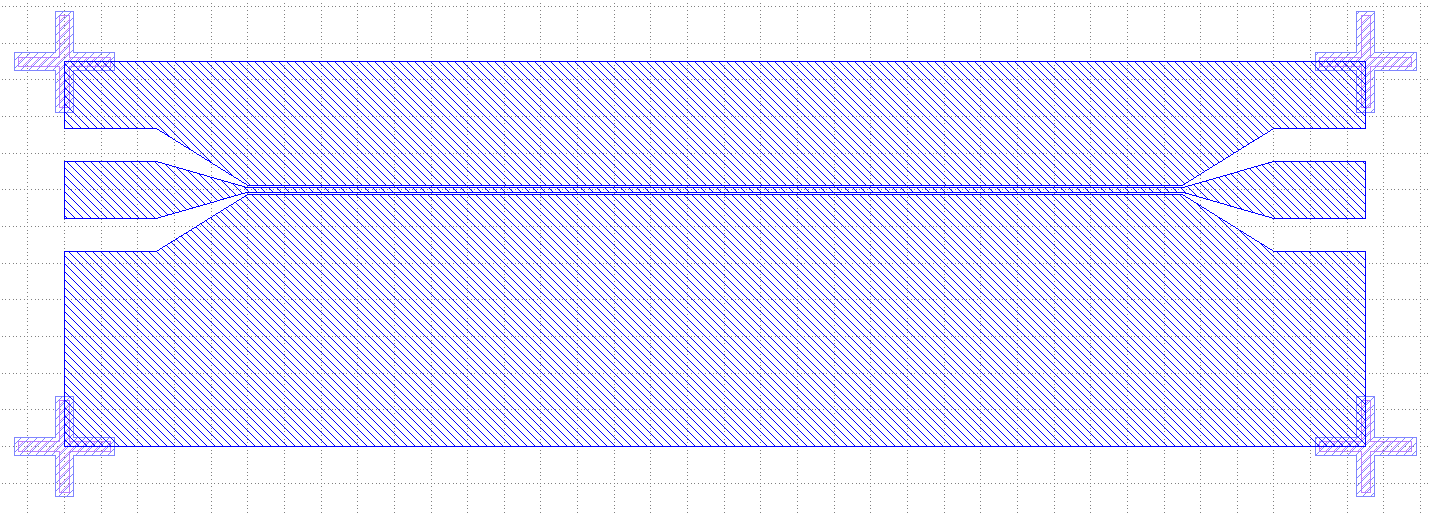

In [26]:
from IPython.display import Image
Image(filename='Z:/DataAnalysis/Notebooks/Design_Tests/First_GDS.png')

Now, let's say we want to add a simple resonator at a certain point. There is a library of available Resonator designs in ClassLib. A simple one would be a EMResonator_TL2Qbit_worm, which would be a $\lambda$/4 resonator



In [27]:
# Define resonator parameters

### Coupling lengths
L_coupling = list(map( lambda x: x*1e3, [200+600]*5 ))
### Main length
L1= np.linspace(600e3, 480e3, 6)

### Turn radius
r = 50e3

### Open end length
L2 = 10e3

### Number of turns in the resonator
N = 3

### Width of the resonator
width_res = 20e3

### Gap between center and ground planes
gap_res = 10e3

### Distance to readout line
toLine = 35e3


 
### Define the CPW
Z_res = CPW( width_res, gap_res, origin, origin )

# Place bottom array of resonators

### Choose number of resonators
N_bottom = 1

###Separation between resonators
delta = 0.5*CHIP.dx/N_bottom

if N_bottom >1:
    step_bot = (CHIP.dx - 2*contact_L - 2*delta)/(N_bottom-1)
else:
    step_bot = (CHIP.dx - 2*contact_L - 2*delta)

resonators = []

for i in range( N_bottom ):
    ### Define the point for the shorted part of the resonator to begin
    point = origin + DPoint( contact_L + delta + i*step_bot, CHIP.dy*2/3 - ((Z0.width + Z_res.width+50e3)/2 + toLine)  )
    
    ### Create the resonator and place it in the main layer
    worm = EMResonator_TL2Qbit_worm( Z_res, point, L_coupling[i], L1[i], r, L2, N)
    worm.place( cell, layer_photo )
    
    ### Append each resonator to the list of resonators
    resonators.append( worm )
    

In [28]:
layout.write(r'Example.gds')

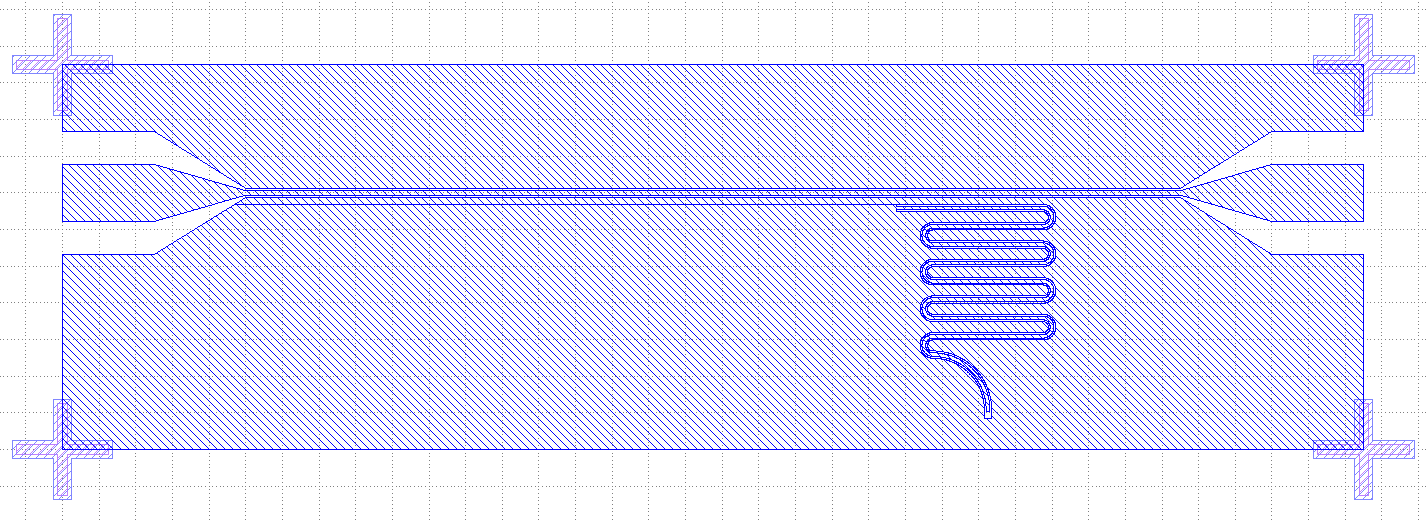

In [18]:
Image(filename='Z:/DataAnalysis/Notebooks/Design_Tests/Readout_with_resonators.png')

Now, let's add some text to a different layer. In order to do that, we will create a box in a different layer, and add text on top.

In [19]:
text_string = "SQD RES"
size_string = 120
X_SIZE = origins[0] + CHIP.dx/2+size_string*1e3*len(text_string)
Y_SIZE = origins[1] + CHIP.dy*6/7+3/2*size_string*1e3

# Box drwaing START #
box = db.Box( origins[0] + CHIP.dx/2, origins[1] + CHIP.dy*6/7, X_SIZE, Y_SIZE )
box_reg = Region( box )
text_reg = db.TextGenerator.default_generator().text("SQD RES", 0.001,size_string,False,-0.5,5)
p0 = Vector( origins[0] + CHIP.dx/2+size_string/2*1e3, origins[1] + CHIP.dy*6/7+size_string/2*1e3)
text_reg.transform( ICplxTrans( 1.0, 0, False, p0 ) )
box_reg -= text_reg
cell.shapes( layer_txt ).insert( box_reg )

## Adding a logo/image (Optional)

We can insert logos or images, such as the UQ logo, into our design. In order to do that, you need a jpg/png image, ideally high resolution, of the logo/image that you want to place.

You also need the nazca-design package installed https://nazca-design.org/

Nazca is a package made to design integrated photonic circuits, but it has some funcionalities that we might want to make use of. In this example, however, it is only explained how to create a gds file from an image.

We create a gds file based on the UQ logo

In [20]:
import nazca as nd

image_link = r'Z:\Talks\UQ Templates\UQ-logos\UQlogoA-mono-M.jpg'
nd.image(image_link, size = 1000).put(origins[0]+2000, origins[1]+500)

nd.export_gds(filename = r'Z:\DataAnalysis\Notebooks\Design_Tests\UQ_Logo.gds')

INFO: bb_util.py: Generating 761x734 pixels image of 761x734 um2, edge is 0 um.
Starting layout export...
...gds generation
...Wrote file 'Z:\DataAnalysis\Notebooks\Design_Tests\UQ_Logo.gds'


Create a new layout in which to paste your new GDS file with the logo in it, and then using the copy_tree() function, add the logo to the main cell. By default, it will be on layer (1, 0), so make sure nothing is in that layer.

In [21]:
image_layout = db.Layout()
image_layout.read(r'Z:\DataAnalysis\Notebooks\Design_Tests\UQ_Logo.gds')

cell.copy_tree(image_layout.top_cell())

[1]

## Perform boolean operations between layers

In order to add our logo to the main design, we can perform Boolean operations between different layers. In order to do that, we use the db.Region() class to encapsulate all the shapes in a given layer. Once the layers are defined, we also need to create a db.ShapeProcessor() object in order to perform operations between layers. In the following example, we take the layer with the main chip and the layer with the UQ logo, and perform a CHIP NOT LOGO operation between the layers.

In [22]:
layer_info_logo = db.LayerInfo(1, 0)
layer_logo = layout.layer(layer_info_logo)

In [23]:
photo_region = db.Region(cell.begin_shapes_rec(layer_logo))
chip_region = db.Region(cell.begin_shapes_rec(layer_photo))

In [24]:
processor = db.ShapeProcessor()

In [25]:
processor.boolean(layout, cell, layer_photo, layout, cell, layer_logo, cell.shapes(layer_photo), db.EdgeProcessor.ModeANotB, True, True, True)

In [26]:
layout.write(r'Example2.gds')

In the same way, we can do more boolean operations. All the defined boolean operations are in the db.EdgeProcessor object.

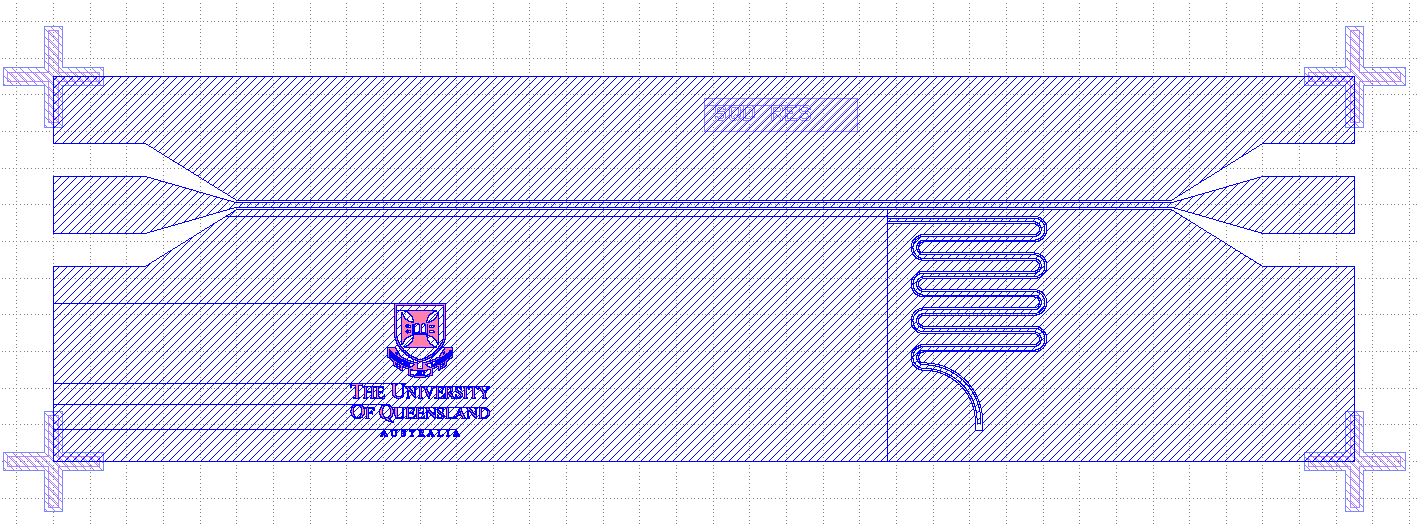

In [27]:
Image(filename='Z:/DataAnalysis/Notebooks/Design_Tests/Chip_With_Logo.png')